# **Transposed Convolutions**


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from PIL import Image

In [2]:
torch.manual_seed(32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Hyperparameters
num_epochs = 20
batch_size = 128
learning_rate = 0.001

In [5]:
# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                        shuffle=False)


100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (32, 16, 16)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (64, 8, 8)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # Output: (128, 4, 4)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.Sigmoid()  # Output: (3, 32, 32)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Instantiate the model
model = ConvAutoencoder().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training finished.")

Epoch [1/20], Loss: 0.2204
Epoch [2/20], Loss: 0.1554
Epoch [3/20], Loss: 0.1521
Epoch [4/20], Loss: 0.1508
Epoch [5/20], Loss: 0.1499
Epoch [6/20], Loss: 0.1495
Epoch [7/20], Loss: 0.1491
Epoch [8/20], Loss: 0.1487
Epoch [9/20], Loss: 0.1484
Epoch [10/20], Loss: 0.1482
Epoch [11/20], Loss: 0.1481
Epoch [12/20], Loss: 0.1478
Epoch [13/20], Loss: 0.1478
Epoch [14/20], Loss: 0.1476
Epoch [15/20], Loss: 0.1474
Epoch [16/20], Loss: 0.1474
Epoch [17/20], Loss: 0.1473
Epoch [18/20], Loss: 0.1471
Epoch [19/20], Loss: 0.1472
Epoch [20/20], Loss: 0.1471
Training finished.


# **Try To Improve The Reconstructions**

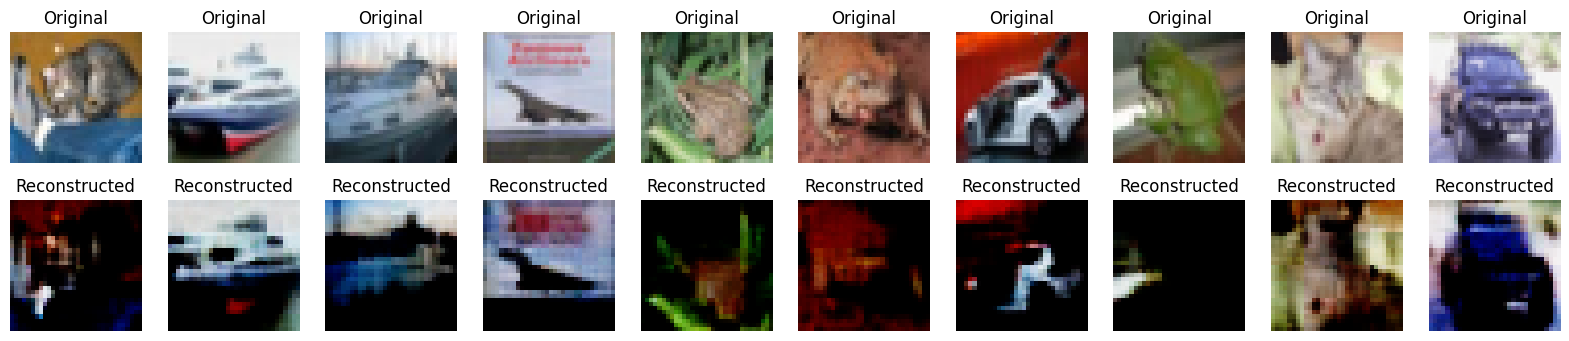

In [ ]:
model.eval()
with torch.no_grad():
    sample_images, _ = next(iter(test_loader))
    sample_images = sample_images.to(device)
    reconstructed = model(sample_images).cpu()

# Plot original and reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    img = (sample_images[i].cpu().numpy().transpose(1, 2, 0) + 1) / 2  # De-normalize
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    img = reconstructed[i].numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

# **Depth and Pointwise Convolution**

In [ ]:
# CNN with standard convolutions
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 32 * 32, 10)  # Assuming input size of 32x32

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# CNN with depthwise separable convolutions
class DepthwiseSeparableBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depthwise_stride=1, pointwise_stride=1):
        super(DepthwiseSeparableBlock, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=depthwise_stride, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=pointwise_stride)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class DepthwiseSeparableCNN(nn.Module):
    def __init__(self):
        super(DepthwiseSeparableCNN, self).__init__()

        self.conv1 = DepthwiseSeparableBlock(3, 64)
        self.conv2 = DepthwiseSeparableBlock(64, 128)

        self.fc1 = nn.Linear(128 * 32 * 32, 10)  # Assuming input size of 32x32

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# Instantiate the models
model_standard = SimpleCNN()
model_depthwise_separable = DepthwiseSeparableCNN()

# Count the number of parameters for each model
params_standard = sum(p.numel() for p in model_standard.parameters())
params_depthwise_separable = sum(p.numel() for p in model_depthwise_separable.parameters())

print("Number of parameters in standard CNN:", params_standard)
print("Number of parameters in depthwise separable CNN:", params_depthwise_separable)


Number of parameters in standard CNN: 1386378
Number of parameters in depthwise separable CNN: 1319976


In [ ]:
model_standard = SimpleCNN().to(device)
model_depthwise_separable = DepthwiseSeparableCNN().to(device)

# Print model summaries
print("Simple CNN Model Summary:")
summary(model_standard, (3, 32, 32))  # Assuming input size of 32x32 and 3 channels

print("\nDepthwise Separable CNN Model Summary:")
summary(model_depthwise_separable, (3, 32, 32))

Simple CNN Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
            Conv2d-2          [-1, 128, 32, 32]          73,856
            Linear-3                   [-1, 10]       1,310,730
Total params: 1,386,378
Trainable params: 1,386,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.50
Params size (MB): 5.29
Estimated Total Size (MB): 6.80
----------------------------------------------------------------

Depthwise Separable CNN Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              30
            Conv2d-2           [-1, 64, 32, 32]             256
DepthwiseSeparableBlock-3          

# **Residual Connections**

In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)  # Residual connection
        out = self.relu(out)

        return out

class ThreeBlockConvLayers(nn.Module):
    def __init__(self, in_channels, block1_channels, block2_channels, block3_channels):
        super(ThreeBlockConvLayers, self).__init__()
        self.block1 = ResidualConvBlock(in_channels, block1_channels, stride=1)
        self.block2 = ResidualConvBlock(block1_channels, block2_channels, stride=2)
        self.block3 = ResidualConvBlock(block2_channels, block3_channels, stride=2)

    def forward(self, x):
        print("Input Image Shape:", x.shape)

        # Block 1
        block1_input = x
        block1_output = self.block1(block1_input)
        print("Block 1 Input Shape:", block1_input.shape)
        print("Block 1 Output Shape:", block1_output.shape)

        # Block 2
        block2_input = block1_output
        block2_output = self.block2(block2_input)
        print("Block 2 Input Shape:", block2_input.shape)
        print("Block 2 Output Shape:", block2_output.shape)

        # Block 3
        block3_input = block2_output
        block3_output = self.block3(block3_input)
        print("Block 3 Input Shape:", block3_input.shape)
        print("Block 3 Output Shape:", block3_output.shape)

        # Final Output
        output = block3_output
        print("Final Output Shape:", output.shape)

        return output

# Example usage:
input_channels = 16
block1_channels = 32
block2_channels = 64
block3_channels = 128

# Create a random input tensor
input_tensor = torch.randn((1, input_channels, 32, 32))

# Instantiate the ThreeBlockConvLayers
three_block_conv_layers = ThreeBlockConvLayers(input_channels, block1_channels, block2_channels, block3_channels)

# Print the shape of the input before and after the Three Block Conv Layers
print("Shape before Three Block Conv Layers:", input_tensor.shape)
output_tensor = three_block_conv_layers(input_tensor)
print("Shape after Three Block Conv Layers:", output_tensor.shape)

Shape before Three Block Conv Layers: torch.Size([1, 16, 32, 32])
Input Image Shape: torch.Size([1, 16, 32, 32])
Block 1 Input Shape: torch.Size([1, 16, 32, 32])
Block 1 Output Shape: torch.Size([1, 32, 32, 32])
Block 2 Input Shape: torch.Size([1, 32, 32, 32])
Block 2 Output Shape: torch.Size([1, 64, 16, 16])
Block 3 Input Shape: torch.Size([1, 64, 16, 16])
Block 3 Output Shape: torch.Size([1, 128, 8, 8])
Final Output Shape: torch.Size([1, 128, 8, 8])
Shape after Three Block Conv Layers: torch.Size([1, 128, 8, 8])


In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.in_channels = in_channels
        self.growth_rate = growth_rate
        self.num_layers = num_layers

        # Define three blocks with different growth rates
        self.block1 = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=1, padding=1)
        )

        self.block2 = nn.Sequential(
            nn.BatchNorm2d(in_channels + growth_rate),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels + growth_rate, 2 * growth_rate, kernel_size=3, stride=1, padding=1)
        )

        self.block3 = nn.Sequential(
            nn.BatchNorm2d(in_channels + 3 * growth_rate),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels + 3 * growth_rate, 3 * growth_rate, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        # Apply block1
        print("Block1 input Shape: ",x.shape)
        block1_output = self.block1(x)
        print("Block 1 Output Shape:", block1_output.shape)

        # Apply block2 with concatenation channel-wise
        block2_input = torch.cat([x, block1_output], 1)
        print("Block 2 input Shape:", block2_input.shape)
        block2_output = self.block2(block2_input)
        print("Block 2 Output Shape:", block2_output.shape)

        # Apply block3 with concatenation channel-wise
        block3_input = torch.cat([x, block1_output, block2_output], 1)
        print("Block 3 input Shape:", block3_input.shape)
        #print(block3_input.shape)
        block3_output = self.block3(block3_input)
        print("Block 3 Output Shape:", block3_output.shape)

        # Concatenate the outputs of all blocks
        output = torch.cat([x, block1_output, block2_output, block3_output], 1)

        return output

# Example usage:
input_channels = 16
growth_rate = 8
num_layers = 4

# Create a random input tensor
input_tensor = torch.randn((1, input_channels, 32, 32))

# Instantiate the Manual Dense Block
manual_dense_block = DenseBlock(input_channels, growth_rate, num_layers)

# Print the shape of the input before and after the Dense Block
print("Shape before Manual Dense Block:", input_tensor.shape)
output_tensor = manual_dense_block(input_tensor)
print("Shape after Manual Dense Block:", output_tensor.shape)

Shape before Manual Dense Block: torch.Size([1, 16, 32, 32])
Block1 input Shape:  torch.Size([1, 16, 32, 32])
Block 1 Output Shape: torch.Size([1, 8, 32, 32])
Block 2 input Shape: torch.Size([1, 24, 32, 32])
Block 2 Output Shape: torch.Size([1, 16, 32, 32])
Block 3 input Shape: torch.Size([1, 40, 32, 32])
Block 3 Output Shape: torch.Size([1, 24, 32, 32])
Shape after Manual Dense Block: torch.Size([1, 64, 32, 32])


# **Depthwise Separable Convolution + Residual Connection**


1.   Design a CNN that uses both Depthwise Separable Convolutions and Residual Connections.
2.   Train the model to classify the CIFAR100 dataset.
3.   Create train, validation and test data.
4.   Plot the validation loss for each epoch.
5.   Report the performance metircs on the test dataset.




In [6]:
# Load CIFAR-100 dataset
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                           download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                          download=True, transform=transform)

100%|██████████| 169M/169M [00:03<00:00, 48.8MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


# **U-NET Image Segmentation**

In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


dataset = torchvision.datasets.OxfordIIITPet(root="./data", split="trainval", target_types="segmentation",
                        download=True, transform=transform, target_transform=target_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

def binary_mask(masks):
    return ((masks < 0.004) | (masks > 0.008)).float()

100%|██████████| 792M/792M [00:29<00:00, 26.6MB/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:02<00:00, 8.21MB/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.enc_conv1 = self.conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc_conv2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.enc_conv3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.enc_conv4 = self.conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec_conv4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = self.conv_block(128, 64)

        # Output layer
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc_conv1(x)
        p1 = self.pool1(e1)

        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)

        e4 = self.enc_conv4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec_conv4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec_conv3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec_conv2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec_conv1(d1)

        output = self.final_conv(d1)
        output = self.sigmoid(output)
        return output

model = UNet().to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        masks = binary_mask(masks)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(dataloader):.4f}")

print("Training complete!")

Epoch [1/20], Loss: 0.4474
Epoch [2/20], Loss: 0.3723
Epoch [3/20], Loss: 0.3364
Epoch [4/20], Loss: 0.3128
Epoch [5/20], Loss: 0.2899
Epoch [6/20], Loss: 0.2763
Epoch [7/20], Loss: 0.2583
Epoch [8/20], Loss: 0.2461
Epoch [9/20], Loss: 0.2365
Epoch [10/20], Loss: 0.2238
Epoch [11/20], Loss: 0.2105
Epoch [12/20], Loss: 0.2064
Epoch [13/20], Loss: 0.2008
Epoch [14/20], Loss: 0.1884
Epoch [15/20], Loss: 0.1780
Epoch [16/20], Loss: 0.1692
Epoch [17/20], Loss: 0.1668
Epoch [18/20], Loss: 0.1628
Epoch [19/20], Loss: 0.1518
Epoch [20/20], Loss: 0.1467
Training complete!


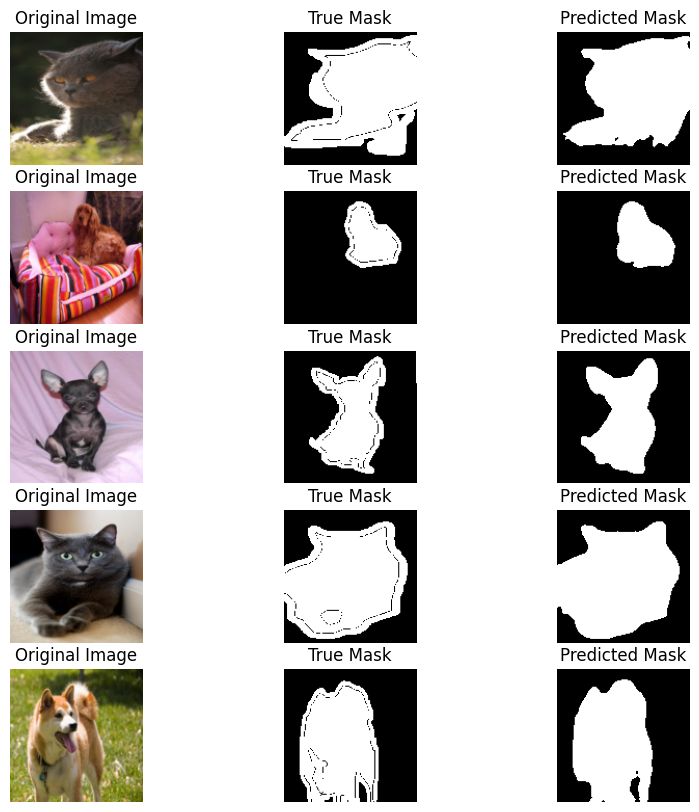

In [ ]:
# Visualize some predictions
model.eval()
images, masks = next(iter(dataloader))
images, masks = images.to(device), masks.to(device)
masks = binary_mask(masks)
num_images = 5

with torch.no_grad():
    predictions = model(images)
    predictions = (predictions > 0.5).float()

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(images[i].cpu().permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(masks[i].cpu().squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(predictions[i].cpu().squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.show()

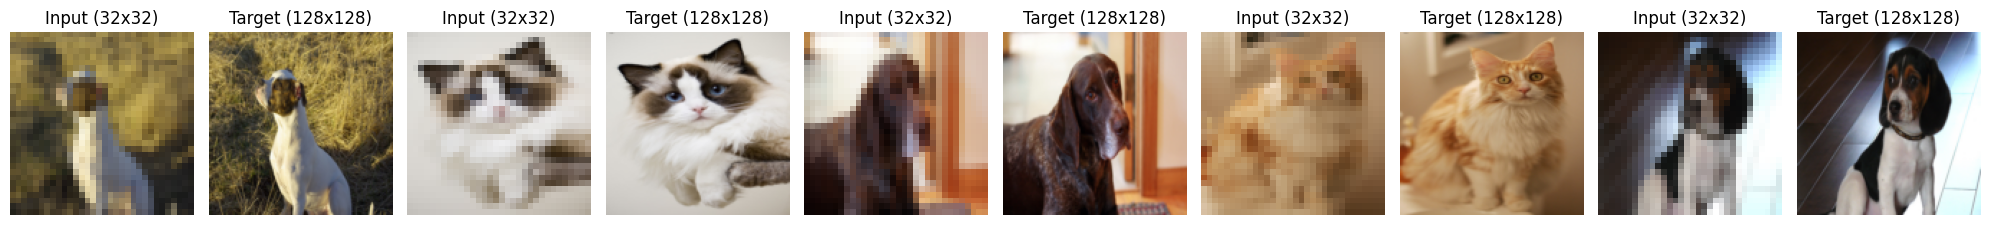

In [11]:
def downsample_image(image):
    image = transforms.Resize((32, 32))(image)
    return transforms.ToTensor()(image)

class SuperResolutionDataset(torchvision.datasets.OxfordIIITPet):
    def __getitem__(self, index):
        image, _ = super().__getitem__(index)
        input_image = downsample_image(image)
        target_image = transform(image)

        return input_image, target_image

train_dataset = SuperResolutionDataset(
    root="./data",
    split="trainval",
    target_types="segmentation",
    download=True,
    transform=None,
    target_transform=None
)

# DataLoader
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True
)

# Visualize samples
def visualize_samples(input_images, target_images, num_samples=5):
    fig, axes = plt.subplots(1, num_samples * 2, figsize=(num_samples * 4, 4))
    for i in range(num_samples):
        input_img = input_images[i].permute(1, 2, 0).numpy()
        target_img = target_images[i].permute(1, 2, 0).numpy()

        axes[i * 2].imshow(input_img)
        axes[i * 2].set_title("Input (32x32)")
        axes[i * 2].axis("off")

        axes[i * 2 + 1].imshow(target_img)
        axes[i * 2 + 1].set_title("Target (128x128)")
        axes[i * 2 + 1].axis("off")
    plt.tight_layout()
    plt.show()

for input_images, target_images in train_loader:
    visualize_samples(input_images, target_images, num_samples=5)
    break